In [8]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

connct = psycopg2.connect('dbname=WhiskyAdvocate user= postgres password = [redacted] host = 127.0.0.1 port=5432')

In [9]:
#Query the database to recover the needed data for unsupervised learning operations

ds_query = ''' SELECT whiskey_stats.percent_abv, vector_description.*
                FROM whiskey_stats
                INNER JOIN vector_description
                ON whiskey_stats.whiskey_id = vector_description.whiskey_id;'''

ml_df = pd.read_sql(ds_query, connct)

ml_df.head()

percent_abv  oak  vanilla  sweet  chocolate  fruit  spice  orange  pepper  \
0         45.0    0        1      0          0      0      0       0       0   
1         40.0    0        0      1          0      0      0       1       0   
2         50.0    2        0      0          0      1      1       0       0   
3         45.2    0        0      1          0      1      0       0       0   
4         45.0    0        0      1          1      0      0       0       0   

   cinnamon  ...  toasted  tobacco  licorice  nuts  floral  bitter  complex  \
0         1  ...        0        0         0     0       0       0        0   
1         0  ...        1        0         0     1       0       0        0   
2         0  ...        0        0         0     0       0       0        0   
3         0  ...        0        0         0     0       0       0        0   
4         0  ...        0        0         0     0       0       0        0   

   subtle  coconut  whiskey_id  
0       0        0           0  
1       0        0           1  
2       0        0           2  
3       0        0           3  
4       0        0           4  

[5 rows x 34 columns]

In [10]:
#close the connection
connct.close()

In [14]:
#check for missing values
ml_df.isnull().sum()

percent_abv    11
oak             0
vanilla         0
sweet           0
chocolate       0
fruit           0
spice           0
orange          0
pepper          0
cinnamon        0
smoke           0
caramel         0
sherry          0
toffee          0
honey           0
apple           0
citrus          0
ginger          0
peat            0
lemon           0
dry             0
leather         0
sugar           0
cherry          0
toasted         0
tobacco         0
licorice        0
nuts            0
floral          0
bitter          0
complex         0
subtle          0
coconut         0
whiskey_id      0
dtype: int64

In [20]:
#loop through the dataframe and replace nulls with the value 40 (default value according to my assumptions when I built this set)

#this loop takes the numeric values from the column and places the in a list
#if it sees a NaN value then it adds the number 40 instead

abv_new = []

for abv in ml_df['percent_abv']:
    if pd.isna(abv) == True:
        abv_new.append(40)
    else:
        abv_new.append(abv)

#abv_new - checking the list showed that it seemed to work

ml_df['percent_abv'] = abv_new

ml_df.isnull().sum()

percent_abv    0
oak            0
vanilla        0
sweet          0
chocolate      0
fruit          0
spice          0
orange         0
pepper         0
cinnamon       0
smoke          0
caramel        0
sherry         0
toffee         0
honey          0
apple          0
citrus         0
ginger         0
peat           0
lemon          0
dry            0
leather        0
sugar          0
cherry         0
toasted        0
tobacco        0
licorice       0
nuts           0
floral         0
bitter         0
complex        0
subtle         0
coconut        0
whiskey_id     0
dtype: int64

# Visualize separation in data using t-SNE

In [11]:
#import libraries for tSNE and min/max scaler to make sure dimensions have equal 
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [21]:
#scale the data using minmaxscaler

scaler = MinMaxScaler().fit(ml_df)

ml_scale = scaler.transform(ml_df)

ml_scale


array([[4.45151033e-01, 0.00000000e+00, 2.50000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.65659777e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.69520258e-04],
       [5.24642289e-01, 3.33333333e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.39040515e-04],
       ...,
       [4.45151033e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.99660959e-01],
       [5.64387917e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.99830480e-01],
       [4.13354531e-01, 1.66666667e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [22]:
# TSNE the scaled data using default hyperparameters and try to visualize it

tsne1 = TSNE(random_state=42)

ws_tsne1 = tsne1.fit_transform(ml_scale)

ws_tsne1

array([[-22.65824  ,  11.752233 ],
       [-19.711933 ,  19.610582 ],
       [-23.824858 ,  47.977947 ],
       ...,
       [ 55.836914 , -29.890766 ],
       [ 14.38859  , -43.450096 ],
       [ -6.1738267, -40.220764 ]], dtype=float32)

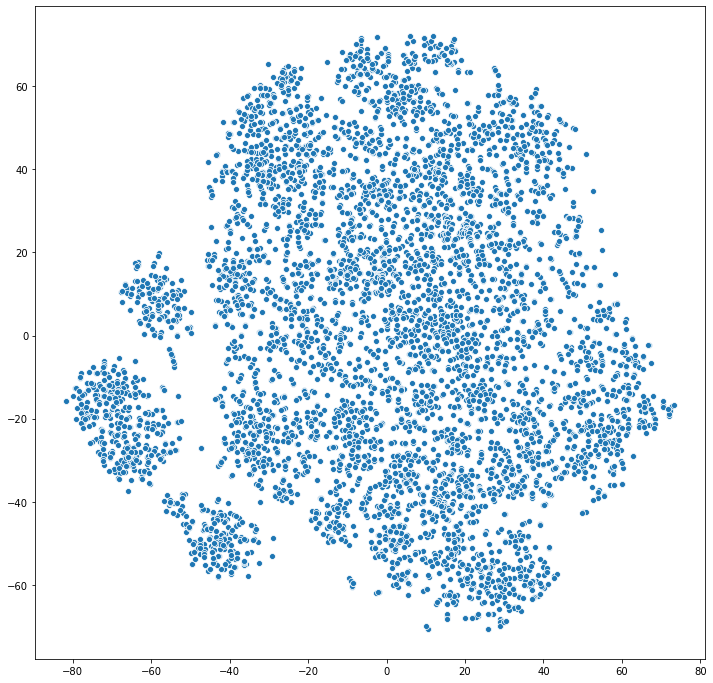

In [27]:
# Unpack and visualize the data from the tsne

tsne_1_x = []
tsne_1_y = []

#I am going to write my unpacking protocol as a function
#this way I can reuse it for additional reps

def tsne_unpack(tsne_array, list1, list2):
    for t in tsne_array:
        list1.append(t[0])
        list2.append(t[1])

tsne_unpack(ws_tsne1, tsne_1_x, tsne_1_y)

#function verified by printing tsne_1_x

#visualize the data using a scatter plot from seaborn
plt.figure(figsize = (12, 12))
sns.scatterplot(x = tsne_1_x, y = tsne_1_y)

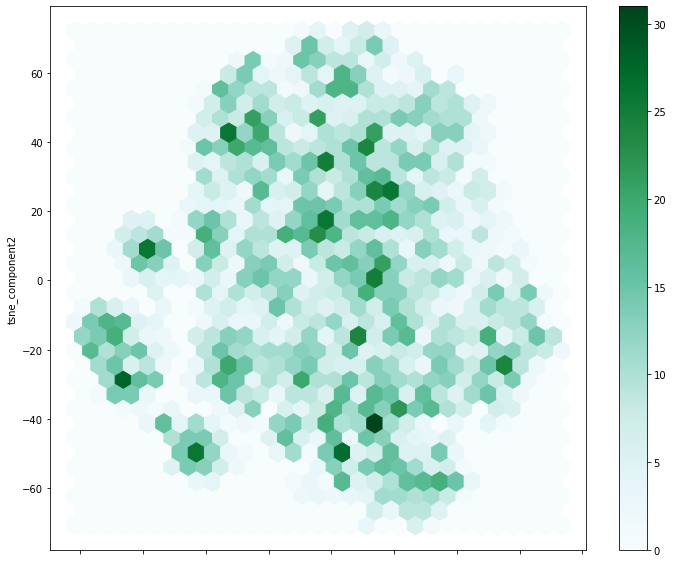

In [34]:
#try to visualize the same thing with a hexbin

tsne_1_dict = {'tsne_component1': tsne_1_x, 'tsne_component2': tsne_1_y}

tsne_vs_df = pd.DataFrame(tsne_1_dict)

tsne_vs_df.plot.hexbin(x = 'tsne_component1', y='tsne_component2', gridsize = 30, figsize = (12, 10))

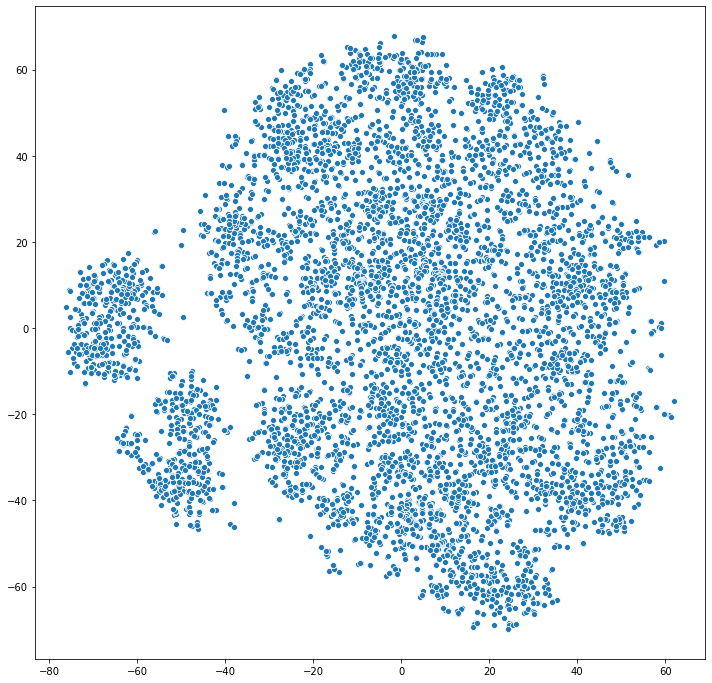

In [43]:
#write a function to aid the optimization run

def visny_tsne(tsne_instantiation):
    
    ws_tsne_iter = tsne_instantiation.fit_transform(ml_scale)
    
    tsne_x = []
    tsne_y = []
    
    tsne_unpack(ws_tsne_iter, tsne_x, tsne_y)
    
    plt.figure(figsize = (12, 12))
    sns.scatterplot(x = tsne_x, y = tsne_y)
    plt.show()
    
tsne2 = TSNE(random_state=42, perplexity = 40)

visny_tsne(tsne2)

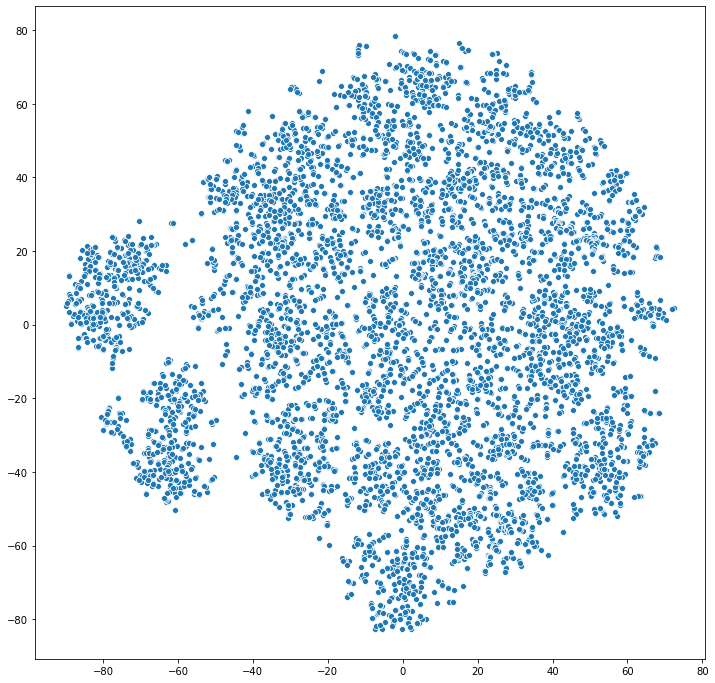

In [44]:
#I can see some clusters, but I'm not satisfied with the separation and want to tune some parameters

tsne3 = TSNE(random_state=42, perplexity = 20)

visny_tsne(tsne3)

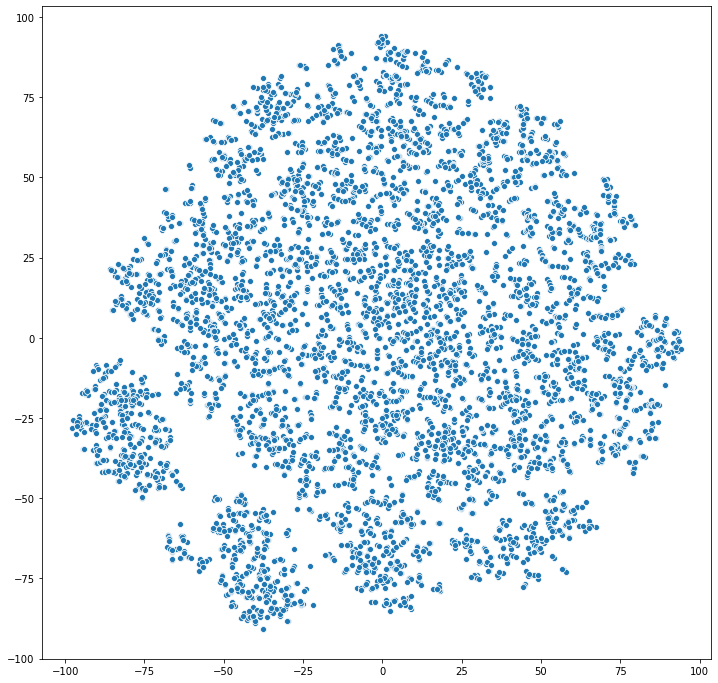

In [45]:
tsne4 = TSNE(random_state=42, perplexity = 10)

visny_tsne(tsne4)

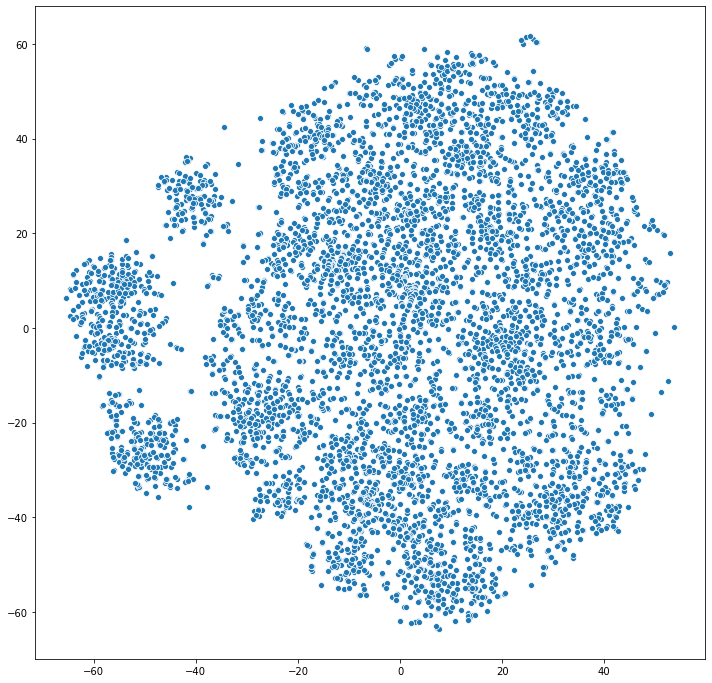

In [46]:
tsne5 = TSNE(random_state=42, perplexity = 50)

visny_tsne(tsne5)

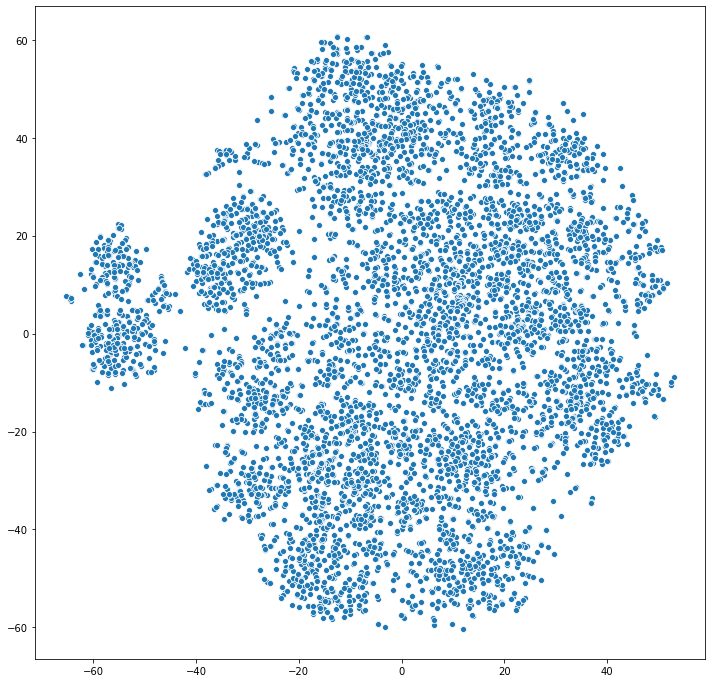

In [47]:
tsne6 = TSNE(random_state=42, perplexity = 50, learning_rate = 300)

visny_tsne(tsne6)

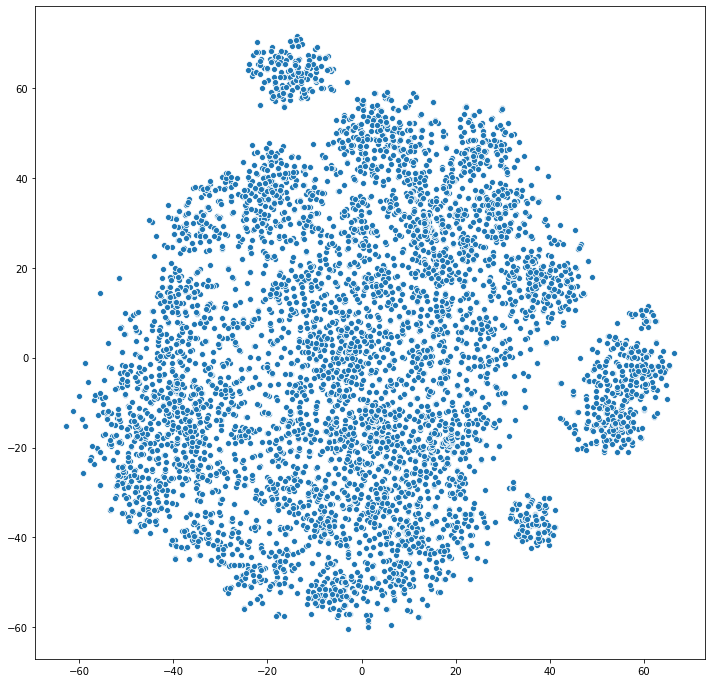

In [48]:
tsne7 = TSNE(random_state=42, perplexity = 50, learning_rate = 600)

visny_tsne(tsne7)

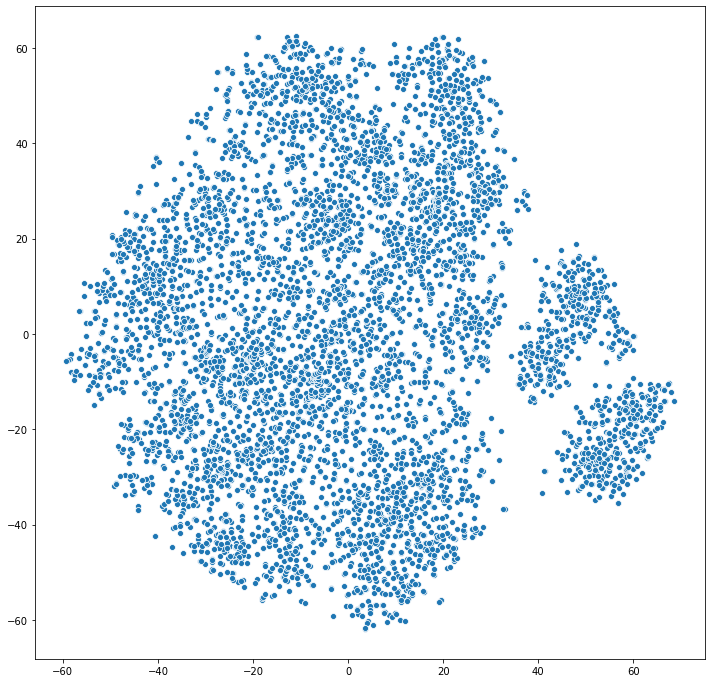

In [49]:
tsne8 = TSNE(random_state=42, perplexity = 50, learning_rate = 450)

visny_tsne(tsne8)

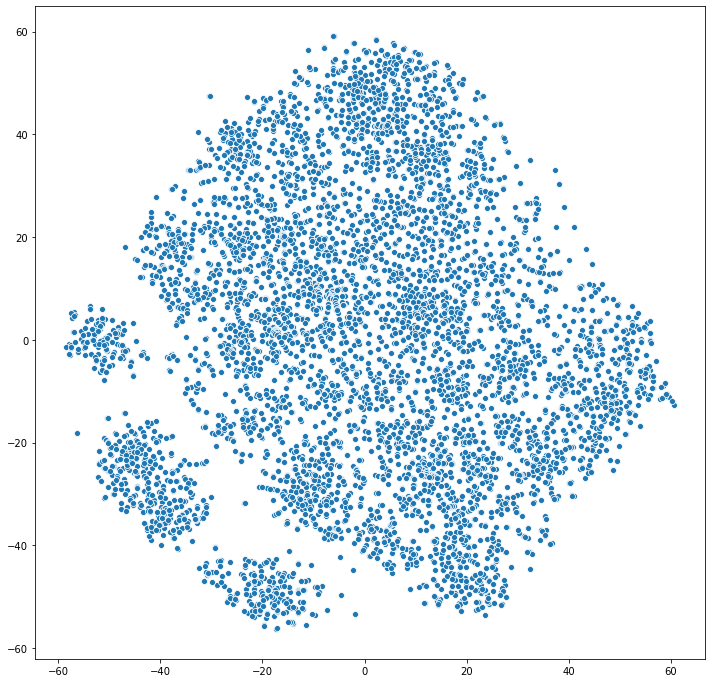

In [51]:
tsne9 = TSNE(random_state=42, perplexity = 50, learning_rate = 100)

visny_tsne(tsne9)

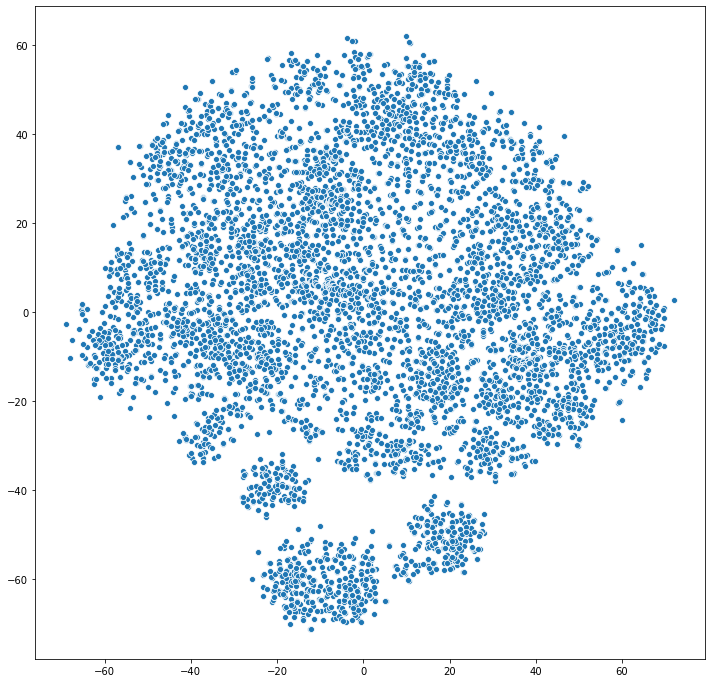

In [52]:
tsne10 = TSNE(random_state=42, perplexity = 50, learning_rate = 1000)

visny_tsne(tsne10)

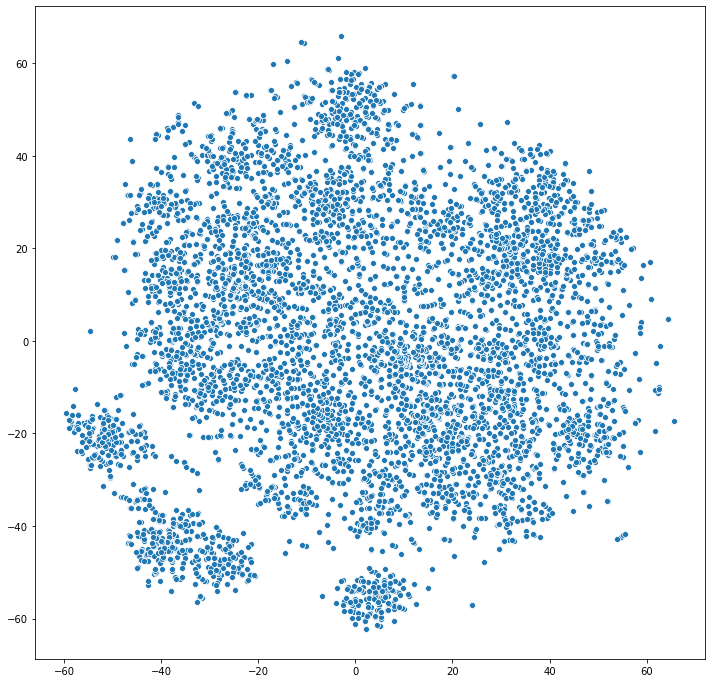

In [53]:
tsne11 = TSNE(random_state=42, perplexity = 50, learning_rate = 1000, early_exaggeration = 20)

visny_tsne(tsne11)

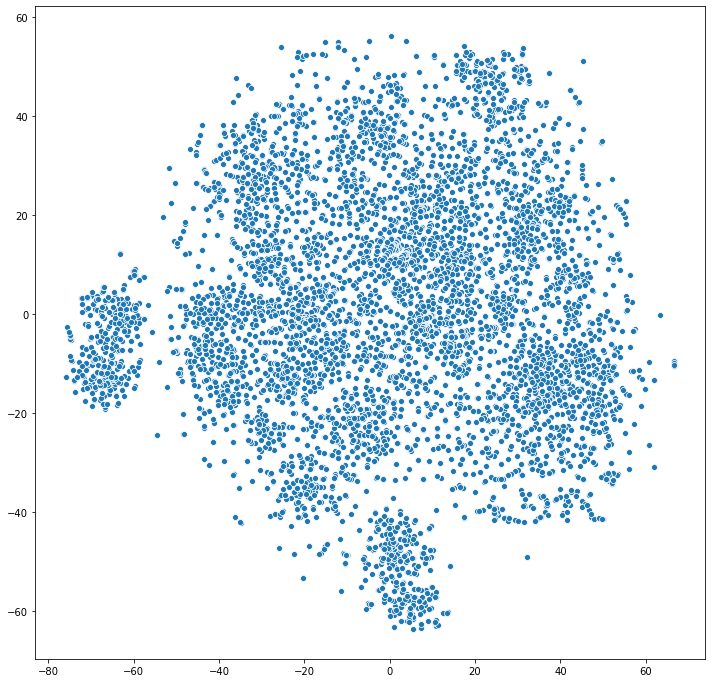

In [54]:
tsne12 = TSNE(random_state=42, perplexity = 50, learning_rate = 1000, early_exaggeration = 30)

visny_tsne(tsne12)

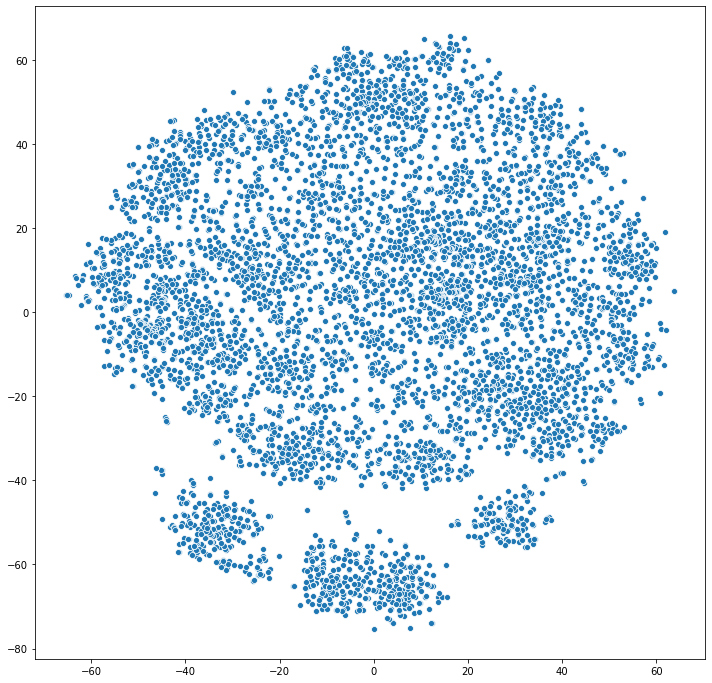

In [55]:
tsne13 = TSNE(random_state=42, perplexity = 50, learning_rate = 1000, early_exaggeration = 6)

visny_tsne(tsne13)

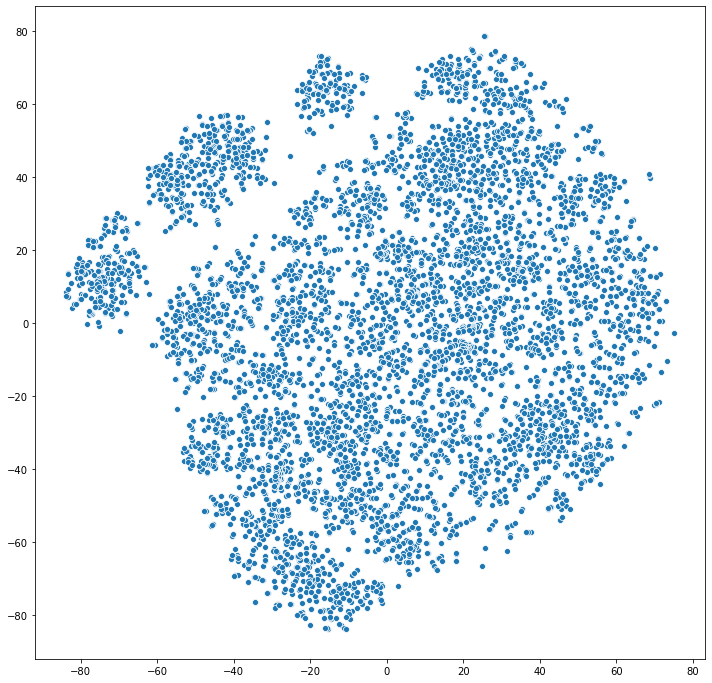

In [56]:
#try lower perplexity with a higher learning rate

tsne14 = TSNE(random_state=42, perplexity = 30, learning_rate = 1000)

visny_tsne(tsne14)

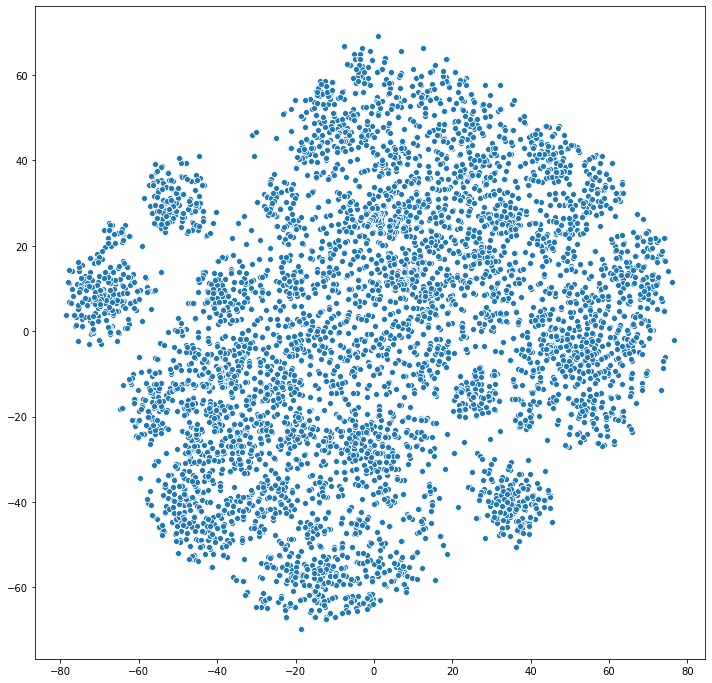

In [57]:
tsne15 = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)

visny_tsne(tsne15)

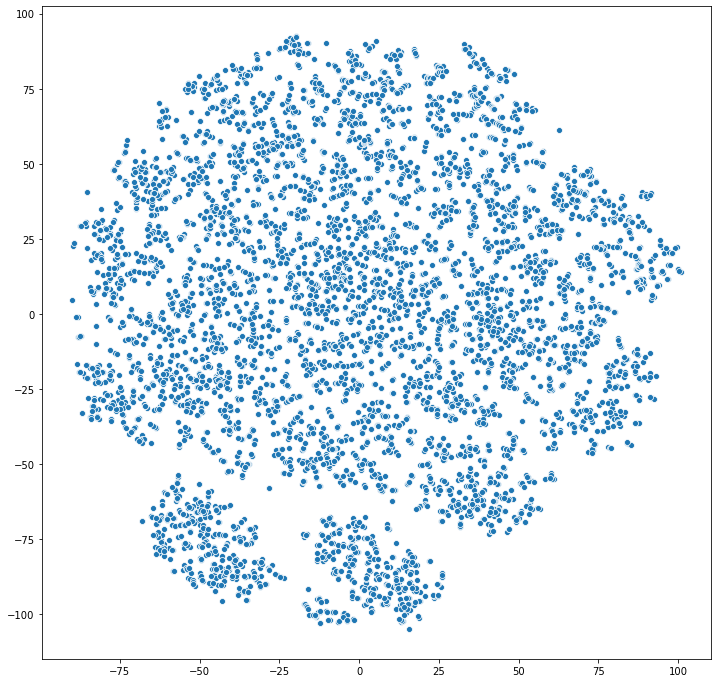

In [58]:
tsne16 = TSNE(random_state=42, perplexity = 10, learning_rate = 1000)

visny_tsne(tsne16)

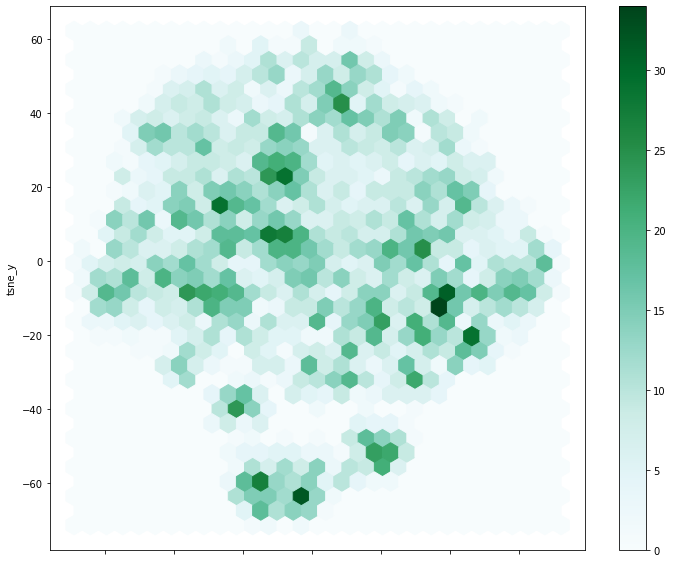

In [60]:
#t-SNE 10 looks like it obtained the best results, although it doesn't look like the data separates that well into clusters
#visualize this tsne using a hexbin plot

ws_tsne_max = tsne10.fit_transform(ml_scale)
    
tsne_x_max = []
tsne_y_max = []
    
tsne_unpack(ws_tsne_max, tsne_x_max, tsne_y_max)

tsne_max_dict = {'tsne_x': tsne_x_max, 'tsne_y': tsne_y_max}

tsne_max_df = pd.DataFrame(tsne_max_dict)

tsne_max_df.plot.hexbin(x = 'tsne_x', y='tsne_y', gridsize = 30, figsize = (12, 10))

plt.show()